# Data Retrieval

This may not work on windows so just use the extracted NIPS papers data from the __`nipstxt/`__ folder present in the same directory as this notebook which already has the data pre-downloaded and extracted

In [1]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2020-08-22 02:08:18--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  21.7MB/s    in 0.6s    

2020-08-22 02:08:18 (21.7 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



# Data Extraction

In [2]:
!tar -xzf nips12raw_str602.tgz

# Load and Pre-process Data

In [3]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips08', 'idx', 'nips09', 'MATLAB_NOTES', 'nips04', 'nips07', 'nips11', 'nips03', 'nips05', 'orig', 'nips06', 'nips02', 'README_yann', 'nips00', 'nips01', 'RAW_DATA_NOTES', 'nips12', 'nips10']


In [7]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    print(folder)
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        #print(file_names)
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

nips00
nips01
nips02
nips03
nips04
nips05
nips06
nips07
nips08
nips09
nips10
nips11
nips12


1740

Co 1740 tai lieu trong papers

In [9]:
print(papers[0][:1000])

573 
BIT - SERIAL NEURAL NETWORKS 
Alan F. Murray, Anthony V. W. Smith and Zoe F. Buffer. 
Department of Electrical Engineering, University of Edinburgh, 
The King's Buildings, Mayfield Road, Edinburgh, 
Scoff and, EH9 3JL. 
ABSTRACT 
A bit - serial VLSI neural network is described from an initial architecture for a 
synapse array through to silicon layout and board design. The issues surrounding bit 
- serial computation, and analog/digital arithmetic are discussed and the parallel 
development of a hybrid analog/digital neural network is outlined. Learning and 
recall capabilities are reported for the bit - serial network along with a projected 
specification for a 64 - neuron, bit - serial board operating at 20 MHz. This tech- 
nique is extended to a 256 (2562 synapses) network with an update time of 3ms, 
using a "paging" technique to time - multiplex calculations through the synapse 
array. 
1. INTRODUCTION 
The functions a synthetic neural network may aspire to mimic are the abil

## Basic Text Wrangling

In [12]:
%%time
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
1740
CPU times: user 28.5 s, sys: 242 ms, total: 28.7 s
Wall time: 29.2 s


In [15]:
print(papers[0][:200])

573 
BIT - SERIAL NEURAL NETWORKS 
Alan F. Murray, Anthony V. W. Smith and Zoe F. Buffer. 
Department of Electrical Engineering, University of Edinburgh, 
The King's Buildings, Mayfield Road, Edinburg


In [13]:
print(norm_papers[0][:50])

['bit', 'serial', 'neural', 'network', 'alan', 'murray', 'anthony', 'smith', 'zoe', 'buffer', 'department', 'electrical', 'engineering', 'university', 'edinburgh', 'king', 'building', 'mayfield', 'road', 'edinburgh', 'scoff', 'eh9', '3jl', 'abstract', 'bit', 'serial', 'vlsi', 'neural', 'network', 'described', 'initial', 'architecture', 'synapse', 'array', 'silicon', 'layout', 'board', 'design', 'issue', 'surrounding', 'bit', 'serial', 'computation', 'analog', 'digital', 'arithmetic', 'discussed', 'parallel', 'development', 'hybrid']


# Text Representation with Feature Engineering

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms. We
leverage the very useful gensim.models.Phrases class for this. This capability helps us
automatically detect common phrases from a stream of sentences, which are typically
multi-word expressions/word n-grams. This implementation draws inspiration
from the famous paper by Mikolov, et al., “Distributed Representations of Words and
Phrases and their Compositionality,” which you can check out at https://arxiv.org/
abs/1310.4546. We start by extracting and generating words and bi-grams as phrases for
each tokenized research paper. We can build this phrase generation model easily with
the following code and test it on a sample paper

I got the solution for the problem , There was two parameters I didn't take care of it which should be passed to Phrases() model, those are

min_count ignore all words and bigrams with total collected count lower than this. Bydefault it value is 5

threshold represents a threshold for forming the phrases (higher means fewer phrases). A phrase of words a and b is accepted if (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold, where N is the total vocabulary size. Bydefault it value is 10.0

In [16]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') 
# higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['bit', 'serial', 'neural_network', 'alan', 'murray', 'anthony', 'smith', 'zoe', 'buffer', 'department_electrical', 'engineering_university', 'edinburgh', 'king', 'building', 'mayfield', 'road', 'edinburgh', 'scoff', 'eh9', '3jl', 'abstract', 'bit', 'serial', 'vlsi', 'neural_network', 'described', 'initial', 'architecture', 'synapse', 'array', 'silicon', 'layout', 'board', 'design', 'issue', 'surrounding', 'bit', 'serial', 'computation', 'analog_digital', 'arithmetic', 'discussed', 'parallel', 'development', 'hybrid', 'analog_digital', 'neural_network', 'outlined', 'learning', 'recall']


In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

In [24]:
print(norm_corpus_bigrams[0])

['bit', 'serial', 'neural_network', 'alan', 'murray', 'anthony', 'smith', 'zoe', 'buffer', 'department_electrical', 'engineering_university', 'edinburgh', 'king', 'building', 'mayfield', 'road', 'edinburgh', 'scoff', 'eh9', '3jl', 'abstract', 'bit', 'serial', 'vlsi', 'neural_network', 'described', 'initial', 'architecture', 'synapse', 'array', 'silicon', 'layout', 'board', 'design', 'issue', 'surrounding', 'bit', 'serial', 'computation', 'analog_digital', 'arithmetic', 'discussed', 'parallel', 'development', 'hybrid', 'analog_digital', 'neural_network', 'outlined', 'learning', 'recall', 'capability', 'reported', 'bit', 'serial', 'network', 'along', 'projected', 'specification', 'neuron', 'bit', 'serial', 'board', 'operating', 'mhz', 'tech_nique', 'extended', 'synapsis', 'network', 'update', 'time', '3ms', 'using', 'paging', 'technique', 'time', 'multiplex', 'calculation', 'synapse', 'array', 'introduction', 'function', 'synthetic', 'neural_network', 'may', 'aspire', 'mimic', 'ability',

In [25]:
# Create a dictionary representation of the documents.
# Dictionary encapsulates the mapping between normalized words and their integer ids.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
dictionary

In [26]:
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '120ns'), (1, '3jl'), (2, '3ms'), (3, '5v'), (4, '8ms'), (5, '_1'), (6, 'ability'), (7, 'able_learn'), (8, 'abstract'), (9, 'acad_sci'), (10, 'accelera'), (11, 'accelerator'), (12, 'access'), (13, 'according'), (14, 'accuracy')]
Total Vocabulary Size: 78892


In [27]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '5v'), (1, '_1'), (2, 'ability'), (3, 'able_learn'), (4, 'abstract'), (5, 'acad_sci'), (6, 'access'), (7, 'according'), (8, 'accuracy'), (9, 'achieve'), (10, 'achieved'), (11, 'acknowledge'), (12, 'acknowledgement_author'), (13, 'acquired'), (14, 'activation')]
Total Vocabulary Size: 7756


Explain dictionary

In [37]:
print(norm_corpus_bigrams[:1])

[['bit', 'serial', 'neural_network', 'alan', 'murray', 'anthony', 'smith', 'zoe', 'buffer', 'department_electrical', 'engineering_university', 'edinburgh', 'king', 'building', 'mayfield', 'road', 'edinburgh', 'scoff', 'eh9', '3jl', 'abstract', 'bit', 'serial', 'vlsi', 'neural_network', 'described', 'initial', 'architecture', 'synapse', 'array', 'silicon', 'layout', 'board', 'design', 'issue', 'surrounding', 'bit', 'serial', 'computation', 'analog_digital', 'arithmetic', 'discussed', 'parallel', 'development', 'hybrid', 'analog_digital', 'neural_network', 'outlined', 'learning', 'recall', 'capability', 'reported', 'bit', 'serial', 'network', 'along', 'projected', 'specification', 'neuron', 'bit', 'serial', 'board', 'operating', 'mhz', 'tech_nique', 'extended', 'synapsis', 'network', 'update', 'time', '3ms', 'using', 'paging', 'technique', 'time', 'multiplex', 'calculation', 'synapse', 'array', 'introduction', 'function', 'synthetic', 'neural_network', 'may', 'aspire', 'mimic', 'ability'

In [40]:
print(len(norm_corpus_bigrams[:1][0]))

2160


In [52]:
a=gensim.corpora.Dictionary(norm_corpus_bigrams[:1])
print('Sample word to number mappings:', list(a.items()))
print('Total Vocabulary Size:', len(a))

Sample word to number mappings: [(0, '120ns'), (1, '3jl'), (2, '3ms'), (3, '5v'), (4, '8ms'), (5, '_1'), (6, 'ability'), (7, 'able_learn'), (8, 'abstract'), (9, 'acad_sci'), (10, 'accelera'), (11, 'accelerator'), (12, 'access'), (13, 'according'), (14, 'accuracy'), (15, 'achieve'), (16, 'achieved'), (17, 'acknowledge'), (18, 'acknowledge_support'), (19, 'acknowledgement_author'), (20, 'aclivry'), (21, 'acquired'), (22, 'activation'), (23, 'activity'), (24, 'add'), (25, 'added'), (26, 'adder'), (27, 'adding'), (28, 'addition'), (29, 'addressed'), (30, 'adjusted'), (31, 'advanced'), (32, 'advanced_research'), (33, 'advantage'), (34, 'afd'), (35, 'agree'), (36, 'aip'), (37, 'alan'), (38, 'algorithm'), (39, 'allow'), (40, 'allowed'), (41, 'allowing'), (42, 'along'), (43, 'alp'), (44, 'alter'), (45, 'although'), (46, 'american_institute'), (47, 'amplifier'), (48, 'analog'), (49, 'analog_digital'), (50, 'analogy'), (51, 'another'), (52, 'anthony'), (53, 'appear'), (54, 'applies'), (55, 'appr

In [53]:
a.filter_extremes(no_below=20, no_above=0.6)
print('Sample word to number mappings:', list(a.items()))
print('Total Vocabulary Size:', len(a))

Sample word to number mappings: []
Total Vocabulary Size: 0


End

In [19]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(2, 2), (6, 1), (7, 1), (26, 1), (33, 1), (34, 1), (36, 1), (44, 1), (47, 1), (57, 4), (66, 1), (68, 1), (72, 1), (75, 3), (77, 10), (98, 4), (109, 1), (110, 3), (116, 2), (118, 1), (122, 1), (125, 1), (130, 3), (153, 1), (159, 1), (181, 1), (193, 1), (196, 1), (201, 1), (203, 2), (231, 1), (237, 1), (241, 2), (242, 7), (245, 1), (251, 1), (269, 3), (286, 1), (293, 1), (332, 1), (339, 1), (340, 6), (342, 1), (346, 2), (347, 1), (352, 1), (358, 2), (359, 3), (365, 3), (371, 2)]


Explain bow_corpus

doc2bow: 
Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

If allow_update is set, then also update dictionary in the process: create ids for new words. At the same time, update document frequencies -- for each word appearing in this document, increase its document frequency (self.dfs) by one.

If allow_update is not set, this function is const, aka read-only.

In [30]:
for text in norm_corpus_bigrams:
  print(text)
  print(dictionary.doc2bow(text))
  break
# Cac tu nay se theo thu tu id xuat hien trong cau (1,2,3,4,5...), moi id nay duoc dem frequency

['bit', 'serial', 'neural_network', 'alan', 'murray', 'anthony', 'smith', 'zoe', 'buffer', 'department_electrical', 'engineering_university', 'edinburgh', 'king', 'building', 'mayfield', 'road', 'edinburgh', 'scoff', 'eh9', '3jl', 'abstract', 'bit', 'serial', 'vlsi', 'neural_network', 'described', 'initial', 'architecture', 'synapse', 'array', 'silicon', 'layout', 'board', 'design', 'issue', 'surrounding', 'bit', 'serial', 'computation', 'analog_digital', 'arithmetic', 'discussed', 'parallel', 'development', 'hybrid', 'analog_digital', 'neural_network', 'outlined', 'learning', 'recall', 'capability', 'reported', 'bit', 'serial', 'network', 'along', 'projected', 'specification', 'neuron', 'bit', 'serial', 'board', 'operating', 'mhz', 'tech_nique', 'extended', 'synapsis', 'network', 'update', 'time', '3ms', 'using', 'paging', 'technique', 'time', 'multiplex', 'calculation', 'synapse', 'array', 'introduction', 'function', 'synthetic', 'neural_network', 'may', 'aspire', 'mimic', 'ability',

End Explain bow_corpus

In [20]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('ability', 2), ('access', 1), ('according', 1), ('aip', 1), ('although', 1), ('american_institute', 1), ('analog', 1), ('approximately', 1), ('architecture', 1), ('assume', 4), ('available', 1), ('become', 1), ('best', 1), ('binary', 3), ('bit', 10), ('circuit', 4), ('complex', 1), ('complexity', 3), ('computing', 2), ('concept', 1), ('conference', 1), ('consequence', 1), ('contribution', 3), ('denker', 1), ('desired', 1), ('easy', 1), ('element', 1), ('end', 1), ('enough', 1), ('essentially', 2), ('feature', 1), ('final', 1), ('fixed', 2), ('follows', 7), ('frequency', 1), ('furthermore', 1), ('hold', 3), ('imple', 1), ('imposes', 1), ('knowledge', 1), ('le', 1), ('learn', 6), ('learned', 1), ('length', 2), ('let', 1), ('limit', 1), ('loaded', 2), ('local', 3), ('low', 3), ('maximum', 2)]


In [21]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


# Topic Models with Latent Semantic Indexing (LSI)

In [54]:
%%time
# Wraning: mat 7 phut (khong phai 56 phut)
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 6min 13s, sys: 1min 41s, total: 7min 55s
Wall time: 4min 51s


In [55]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
-0.487*"neuron" + -0.396*"cell" + 0.257*"state" + -0.191*"response" + 0.187*"training" + -0.170*"stimulus" + -0.117*"activity" + 0.109*"class" + -0.099*"spike" + -0.097*"pattern" + -0.096*"circuit" + -0.096*"synaptic" + 0.095*"vector" + -0.090*"signal" + -0.090*"firing" + -0.088*"visual" + 0.084*"classifier" + 0.083*"action" + 0.078*"word" + -0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"clas

In [56]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()
    

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('state', 0.257), ('training', 0.187), ('class', 0.109), ('vector', 0.095), ('classifier', 0.084), ('action', 0.083), ('word', 0.078)]
--------------------------------------------------
Direction 2: [('neuron', -0.487), ('cell', -0.396), ('response', -0.191), ('stimulus', -0.17), ('activity', -0.117), ('spike', -0.099), ('pattern', -0.097), ('circuit', -0.096), ('synaptic', -0.096), ('signal', -0.09), ('firing', -0.09), ('visual', -0.088), (

In [57]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


((7756, 10), (10,), (10, 1740))

In [58]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.039,-0.018,-0.078,-0.010,0.011,0.066,0.027,0.022,0.034,-0.026
1,0.016,-0.017,-0.013,-0.008,-0.024,0.028,-0.000,0.019,-0.008,0.006
2,0.025,0.010,0.019,-0.023,0.014,0.006,-0.001,-0.001,0.017,-0.014
3,0.030,-0.046,-0.011,-0.026,-0.057,0.046,0.017,0.009,-0.048,0.017
4,0.032,0.018,0.016,-0.017,-0.055,0.013,0.007,0.064,0.013,-0.031
5,0.010,-0.005,-0.010,-0.009,-0.011,0.017,-0.013,0.003,0.005,-0.010
6,0.019,0.003,0.014,0.032,-0.011,0.002,0.011,0.041,0.029,0.016
7,0.029,-0.028,-0.010,-0.016,-0.031,0.031,-0.005,-0.035,0.007,-0.000
8,0.038,-0.003,0.009,0.078,0.023,0.031,-0.044,0.015,0.068,-0.037
9,0.029,-0.052,0.001,0.021,-0.003,-0.055,0.041,0.052,0.019,0.013


In [59]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T9', 'T6', 'T8']
Paper Summary:
74O 
SPATIAL ORGANIZATION OF NEURAL NETWORKS: 
A PROBABILISTIC MODELING APPROACH 
A. Stafylopati s 
M. Dikaiakos 
D. Kontoravdi s 
National Technical University of Athens, Department of Electri- 
cal Engineering, Computer Science Division, 157 73 Zographos, 
Athens, Greece. 
ABSTRACT 
The aim of this paper is to explore the spatial organization of 
neural networks under Markovian assumptions, in what concerns the be- 
haviour of individual cells and the interconnection mechanism. Space- 
organiz

Document #250:
Dominant Topics (top 3): ['T1', 'T2', 'T9']
Paper Summary:
60 Nelson and Bower 
Computational E.ciency: 
A Common Organizing Principle for 
Parallel Computer Maps and Brain Maps 
Mark E. Nelson James M. Bower 
Computation and Neural Systems Program 
Division of Biology, 216-76 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
It is well-known that neural responses in particular brain region

# Implementing LSI Topic Models from Scratch

In [ ]:
td_matrix = gensim.matutils.corpus2dense(corpus=bow_corpus, num_terms=len(dictionary))
print(td_matrix.shape)
td_matrix

(7756, 1740)


array([[1., 0., 1., ..., 0., 2., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
vocabulary = np.array(list(dictionary.values()))
print('Total vocabulary size:', len(vocabulary))
vocabulary

Total vocabulary size: 7756


array(['able', 'abstract', 'accommodate', ..., 'support_vector',
       'mozer_jordan', 'kearns_solla'], dtype='<U28')

In [ ]:
dictionary[0]

'able'

In [ ]:
from scipy.sparse.linalg import svds

u, s, vt = svds(td_matrix, k=TOTAL_TOPICS, maxiter=10000)
term_topic = u
singular_values = s
topic_document = vt
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [ ]:
tt_weights = term_topic.transpose() * singular_values[:, None]
tt_weights.shape

(10, 7756)

In [ ]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(tt_weights), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([tt_weights[row, columns] 
                             for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t, w) for t, w in zip(terms, weights)], 
                          key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('training', 92.618), ('task', 80.732), ('pattern', 70.619), ('classifier', 56.989), ('control', 50.677), ('rule', 45.926), ('action', 41.202), ('neuron', 38.193)]
--------------------------------------------------
Direction 2: [('word', -188.488), ('vector', -85.973), ('node', -54.376), ('recognition', -53.232), ('sequence', -50.351), ('circuit', -45.394), ('cell', -44.811), ('hmm', -34.086), ('character', -34.022), ('chip', -32.16), ('matrix', -32.093), ('structure', -30.993)]
--------------------------------------------------

Topic #2:
Direction 1: [('word', 78.347), ('neuron', 69.793), ('stimulus', 63.234), ('feature', 53.819), ('distribution', 53.119), ('response', 30.954), ('state', 29.343), ('probability', 29.099), ('estimate', 28.908)]
--------------------------------------------------
Direction 2: [('node', -173.277), ('circuit', -93.0), ('chip', -73.593), ('classifier', -58.717), ('current', -55.844), ('voltage', -53.489), ('control', -51.708), ('rule

In [ ]:
import pandas as pd

document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,-0.005,0.000,0.072,0.030,0.018,0.010,-0.077,0.009,-0.002,-0.038
1,-0.007,0.001,0.017,0.013,0.016,-0.011,0.008,-0.022,-0.000,-0.022
2,0.014,0.008,-0.009,-0.008,-0.000,0.003,0.003,-0.004,0.028,-0.021
3,-0.016,-0.003,0.011,-0.002,-0.044,0.023,0.003,0.011,0.048,-0.024
4,-0.036,-0.061,0.050,-0.006,-0.058,0.003,0.013,-0.013,0.020,-0.032
5,-0.020,-0.040,0.137,-0.087,-0.307,0.019,-0.022,-0.003,0.183,-0.085
6,0.012,-0.002,0.014,-0.012,0.042,-0.017,0.003,-0.019,0.034,-0.020
7,0.013,-0.003,-0.005,-0.004,0.001,-0.008,-0.018,0.007,-0.006,-0.012
8,0.011,0.011,0.019,-0.020,-0.009,-0.018,0.003,-0.017,0.071,-0.033
9,-0.006,-0.005,-0.006,0.036,0.008,0.016,0.041,0.027,-0.007,-0.027


In [ ]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T5', 'T10', 'T9']
Paper Summary:
9 
Stochastic Learning Networks and their Electronic Implementation 
Joshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana 
Bell Communications Research, Morristown, NJ 07960 
ABSTRACT
We describe a family of learning algorithms that operate on a recurrent, symmetrically 
connected, neuromorphic network that, like the Boltzmann machine, settles in the 
presence of noise. These networks learn by modifying synaptic connection strengths on 
the basis of correlations seen loca

Document #250:
Dominant Topics (top 3): ['T6', 'T8', 'T3']
Paper Summary:
266 Zemel, Mozer and Hinton 
TRAFFIC: Recognizing Objects Using 
Hierarchical Reference Frame Transformations 
Richard S. Zemel 
Computer Science Dept. 
University of Toronto 
Toronto, ONT M5S 1A4 
Michael C. Mozer 
Computer Science Dept. 
University of Colorado 
Boulder, CO 80309-0430 
Geoffrey E. Hinton 
Computer Science Dept. 
University of Toro

# Topic Models with Latent Dirichlet Allocation (LDA)

In [ ]:
%%time
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 5min 32s, sys: 10.7 s, total: 5min 43s
Wall time: 2min 31s


In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.016*"training" + 0.012*"classifier" + 0.007*"pattern" + 0.007*"classification" + 0.006*"class" + 0.006*"task" + 0.006*"vector" + 0.005*"training_set" + 0.005*"feature" + 0.004*"control" + 0.004*"size" + 0.003*"trained" + 0.003*"teacher" + 0.003*"rate" + 0.003*"student" + 0.003*"average" + 0.003*"robot" + 0.003*"random" + 0.003*"rule" + 0.003*"search"

Topic #2:
0.008*"vector" + 0.006*"equation" + 0.006*"matrix" + 0.006*"neuron" + 0.005*"state" + 0.005*"dynamic" + 0.005*"solution" + 0.005*"unit" + 0.004*"node" + 0.004*"pattern" + 0.004*"linear" + 0.004*"let" + 0.003*"layer" + 0.003*"convergence" + 0.003*"rule" + 0.003*"size" + 0.003*"theorem" + 0.003*"threshold" + 0.003*"memory" + 0.003*"theory"

Topic #3:
0.017*"training" + 0.011*"word" + 0.008*"recognition" + 0.007*"trained" + 0.006*"net" + 0.006*"unit" + 0.006*"feature" + 0.006*"speech" + 0.006*"task" + 0.005*"architecture" + 0.005*"class" + 0.005*"character" + 0.004*"layer" + 0.004*"classification" + 0.004*"context" + 0.

In [ ]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0433305600965899


In [ ]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('training', 0.017), ('word', 0.011), ('recognition', 0.008), ('trained', 0.007), ('net', 0.006), ('unit', 0.006), ('feature', 0.006), ('speech', 0.006), ('task', 0.006), ('architecture', 0.005), ('class', 0.005), ('character', 0.005), ('layer', 0.004), ('classification', 0.004), ('context', 0.004), ('test', 0.004), ('sequence', 0.004), ('hidden_unit', 0.004), ('experiment', 0.004), ('vector', 0.004)]

Topic #2:
[('unit', 0.03), ('pattern', 0.009), ('representation', 0.007), ('activation', 0.007), ('hidden_unit', 0.006), ('node', 0.006), ('structure', 0.006), ('layer', 0.006), ('activity', 0.005), ('connection', 0.004), ('task', 0.004), ('component', 0.004), ('map', 0.004), ('rule', 0.004), ('architecture', 0.004), ('signal', 0.004), ('level', 0.004), ('response', 0.003), ('connectionist', 0.003), ('training', 0.003)]

Topic #3:
[('neuron', 0.021), ('cell', 0.019), ('response', 0.009), ('activity', 0.007), ('stimulus', 0.007), ('pattern', 0.007), ('sp

In [ ]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['training', 'word', 'recognition', 'trained', 'net', 'unit', 'feature', 'speech', 'task', 'architecture', 'class', 'character', 'layer', 'classification', 'context', 'test', 'sequence', 'hidden_unit', 'experiment', 'vector']

Topic #2:
['unit', 'pattern', 'representation', 'activation', 'hidden_unit', 'node', 'structure', 'layer', 'activity', 'connection', 'task', 'component', 'map', 'rule', 'architecture', 'signal', 'level', 'response', 'connectionist', 'training']

Topic #3:
['neuron', 'cell', 'response', 'activity', 'stimulus', 'pattern', 'spike', 'synaptic', 'cortical', 'neural', 'signal', 'firing', 'connection', 'effect', 'layer', 'et_al', 'cortex', 'visual', 'simulation', 'synapsis']

Topic #4:
['image', 'object', 'feature', 'pixel', 'visual', 'representation', 'face', 'vector', 'view', 'recognition', 'transformation', 'local', 'map', 'structure', 'region', 'filter', 'position', 'distance', 'part', 'location']

Topic #5:
['vector', 'equation'

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.47028476052247825
Avg. Coherence Score (UMass): -1.0433305600965896
Model Perplexity: -7.792233498252204


# LDA Models with MALLET

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2018-11-08 20:06:13--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  1.35MB/s    in 12s     

2018-11-08 20:06:25 (1.28 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip -q mallet-2.0.8.zip

In [ ]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=16)

In [ ]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_mallet.show_topic(n, topn=20)] 
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'signal', 'spike', 'effect', 'synaptic', 'frequency', 'neural', 'unit', 'connection', 'layer', 'cortical', 'firing', 'et_al', 'brain', 'temporal']

Topic #2:
['prediction', 'control', 'trajectory', 'target', 'task', 'expert', 'training', 'nonlinear', 'dynamic', 'linear', 'local', 'change', 'adaptive', 'mapping', 'hand', 'movement', 'controller', 'position', 'motor', 'architecture']

Topic #3:
['vector', 'equation', 'linear', 'bound', 'solution', 'theory', 'matrix', 'convergence', 'theorem', 'defined', 'size', 'constant', 'optimal', 'class', 'eq', 'property', 'approximation', 'condition', 'rate', 'probability']

Topic #4:
['state', 'action', 'step', 'policy', 'environment', 'recurrent', 'transition', 'optimal', 'task', 'reinforcement_learning', 'control', 'path', 'goal', 'stochastic', 'sequence', 'current', 'cost', 'iteration', 'machine', 'update']

Topic #5:
['image', 'object', 'feature', 'motion', 'visual', 'm

In [ ]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5008326905758488
Avg. Coherence Score (UMass): -1.0635635291342118
Model Perplexity: -8.53533


# LDA Tuning - Finding Optimal Number of Topics

In [ ]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=16)

100%|██████████| 29/29 [37:48<00:00, 92.53s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
24,26,0.5461
23,25,0.5427
17,19,0.5419
16,18,0.5412
22,24,0.5405
18,20,0.5401
21,23,0.5375
20,22,0.5369
19,21,0.5369
27,29,0.5363


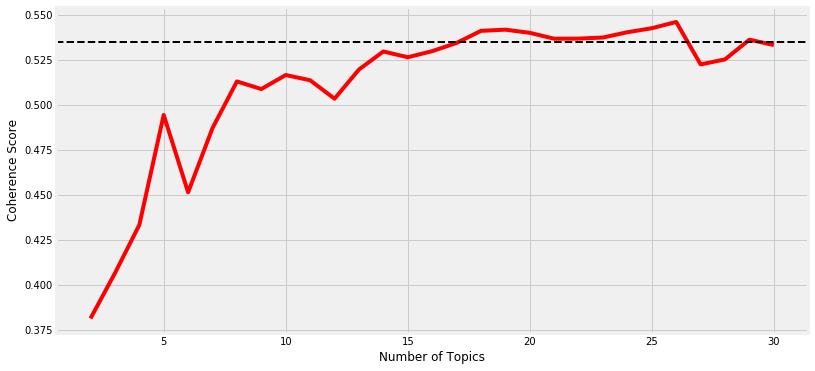

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [ ]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['class', 'classification', 'classifier', 'training', 'pattern', 'feature', 'kernel', 'machine', 'training_set', 'test', 'sample', 'vector', 'database', 'error_rate', 'margin', 'experiment', 'support_vector', 'nearest_neighbor', 'decision', 'size']

Topic #2:
['neuron', 'memory', 'pattern', 'dynamic', 'connection', 'phase', 'attractor', 'capacity', 'state', 'hopfield', 'neural', 'fixed_point', 'oscillator', 'delay', 'stable', 'fig', 'oscillation', 'associative_memory', 'behavior', 'stored']

Topic #3:
['word', 'recognition', 'training', 'speech', 'character', 'context', 'hmm', 'letter', 'mlp', 'speaker', 'feature', 'frame', 'trained', 'speech_recognition', 'phoneme', 'experiment', 'hybrid', 'segmentation', 'vowel', 'level']

Topic #4:
['noise', 'rate', 'equation', 'curve', 'average', 'correlation', 'rule', 'distribution', 'theory', 'limit', 'solution', 'optimal', 'eq', 'teacher', 'effect', 'size', 'temperature', 'student', 'line', 'random']

Topic #5:
['bound', 'theorem', 'cl

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,class,neuron,word,noise,bound,vector,search,distribution,visual,neuron,state,node,image,control,unit,circuit,rule,vector,signal,prediction
Term2,classification,memory,recognition,rate,theorem,matrix,task,probability,motion,cell,sequence,tree,object,action,layer,chip,representation,map,filter,training
Term3,classifier,pattern,training,equation,class,linear,experiment,prior,cell,spike,step,structure,feature,state,training,current,module,distance,frequency,estimate
Term4,training,dynamic,speech,curve,probability,equation,table,gaussian,response,synaptic,recurrent,graph,pixel,policy,hidden_unit,analog,structure,cluster,source,regression
Term5,pattern,connection,character,average,size,solution,instance,variable,stimulus,activity,transition,code,face,environment,net,voltage,human,local,channel,test
Term6,feature,phase,context,correlation,threshold,gradient,test,mixture,direction,response,stochastic,level,view,controller,architecture,implementation,movement,dimension,noise,noise
Term7,kernel,attractor,hmm,rule,proof,constraint,domain,density,receptive_field,stimulus,iteration,bit,recognition,reinforcement_learning,pattern,processor,motor,clustering,component,selection
Term8,machine,capacity,letter,distribution,polynomial,convergence,target,bayesian,map,firing,update,path,representation,task,activation,bit,target,mapping,response,variance
Term9,training_set,state,mlp,theory,theory,optimization,query,estimate,spatial,synapsis,dynamic,local,shape,optimal,trained,design,language,dimensional,temporal,training_set
Term10,test,hopfield,speaker,limit,complexity,nonlinear,feature,approximation,orientation,et_al,probability,size,scale,robot,task,device,subject,region,sound,sample


In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, decision, size"
Topic2,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored"
Topic3,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level"
Topic4,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random"
Topic5,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded"
Topic6,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic, energy"
Topic7,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important"
Topic8,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, entropy"
Topic9,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern"
Topic10,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate"


# Interpreting Topic Model Results

In [ ]:
tm_results = best_lda_model[bow_corpus]

In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(16, 0.2115988756613756),
 (5, 0.29989652050187554),
 (9, 0.3307915758896151),
 (8, 0.5447463768115942),
 (9, 0.18093823158652983)]

In [ ]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

## Dominant Topics Distribution across Corpus

In [ ]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                    '% Total Docs': np.size }
                                              })
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

/home/paperspace/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,75,4.31,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, deci..."
1,2,69,3.97,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored"
2,3,78,4.48,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level"
3,4,68,3.91,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random"
4,5,105,6.03,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded"
5,6,80,4.60,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic..."
6,7,66,3.79,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important"
7,8,148,8.51,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent..."
8,9,117,6.72,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern"
9,10,141,8.10,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate"


## Dominant Topics in Specific Research Papers

In [ ]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,13,29.10,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","622 \nLEARNING A COLOR ALGORITHM FROM EXAMPLES \nAnya C. Hurlbert and Tomaso A. Poggio \nArtificial Intelligence Laboratory and Department of Brain and Cognitive Sciences, \nMassachusetts Institut..."
13,13,16,27.12,"circuit, chip, current, analog, voltage, implementation, processor, bit, design, device, computation, parallel, digital, operation, array, neural, synapse, element, hardware, transistor","9 \nStochastic Learning Networks and their Electronic Implementation \nJoshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana \nBell Communications Research, Morristown, NJ 0..."
17,17,5,23.00,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","338 \nThe Connectivity Analysis of Simple Association \nHow Many Connections Do You Need? \nDan Hammerstrom * \nOregon Graduate Center, Beaverton, OR 97006 \nABSTRACT \nThe efficient realization, ..."
392,392,14,67.03,"control, action, state, policy, environment, controller, reinforcement_learning, task, optimal, robot, goal, step, reward, td, agent, adaptive, cost, reinforcement, trial, exploration","Integrated Modeling and Control \nBased on Reinforcement Learning \nand Dynamic Programming \nRichard S. Sutton \nGTE Laboratories Incorporated \nWaltham, MA 02254 \nAbstract \nThis is a summary o..."
503,503,3,60.76,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Multi-State Time Delay Neural Networks \nfor Continuous Speech Recognition \nPatrick Haffner \nCNET Lannion A TSS/RCP \n22301 LANNION, FRANCE \nhaffnerlannion.cnet. fr \nAlex Waibel \nCarnegie Me..."
681,681,3,67.58,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
733,733,16,45.55,"circuit, chip, current, analog, voltage, implementation, processor, bit, design, device, computation, parallel, digital, operation, array, neural, synapse, element, hardware, transistor","High Performance Neural Net Simulation \non a Multiprocessor System with \n""Intelligent"" Communication \nUrs A. Miiller, Michael Kocheisen, and Anton Gunzinger \nElectronics Laboratory, Swiss Fede..."
906,906,10,56.44,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate","A model of the hippocampus combining self- \norganization and associative memory function. \nMichael E. Hasselmo, Eric Schnell \nJoshua Berke and Edi Barkai \nDept. of Psychology, Harvard Universi..."
996,996,19,65.69,"signal, filter, frequency, source, channel, noise, component, response, temporal, sound, auditory, detection, phase, ica, adaptation, amplitude, subject, eeg, change, correlation","Using Feedforward Neural Networks to \nMonitor Alertness from Changes in EEG \nCorrelation and Coherence \nScott Makeig \nNaval Health Research Center, P.O. Box 85122 \nSan Diego, CA 92186-5122 \n..."
1622,1622,8,56.70,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent...","The Infinite Gaussian Mixture Model \nCarl Edward Rasmussen \nDepartment of Mathematical Modellin

## Relevant Research Papers per Topic based on Dominance

In [ ]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,1138,1,61.01,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, deci...","Improving the Accuracy and Speed of \nSupport Vector Machines \nChris J.C. Burges \nBell Laboratories \nLucent Technologies, Room 3G429 \n101 Crawford's Corner Road \nHolmdel, NJ 07733-3030 \nburg..."
2,131,2,56.71,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."
3,681,3,67.58,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
4,1570,4,73.69,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random","Dynamics of Supervised Learning with \nRestricted Training Sets \nA.C.C. Coolen \nDept of Mathematics \nKing's College London \nStrand, London WC2R 2LS, UK \ntcoolen @mth.kcl.ac.uk \nD. Saad \nNeu..."
5,431,5,81.06,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversi..."
6,82,6,57.12,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic...","612 \nConstrained Differential Optimization \nJohn C. Platt \nAlan H. Ban' \nCalifornia Institute of Technology, Pasadena, CA 91125 \nAbstract \nMany optimization models of neural networks need co..."
7,741,7,62.82,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important","When Will a Genetic Algorithm \nOutperform Hill Climbing? \nMelanie Mitchell \nSanta Fe Institute \n1660 Old Pecos Trail, Suite A \nSanta Fe, NM 87501 \nJohn H. Holland \nDept. of Psychology \nUni..."
8,1375,8,61.11,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent...",Approximating Posterior Distributions \nin Belief Networks using Mixtures \nChristopher M. Bishop \nNeil Lawrence \nNeural Computing Research Group \nDept. Computer Science & Applied Mathematics \...
9,808,9,66.59,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern","Development of Orientation and Ocular \nDominance Columns in Infant Macaques \nKlaus Obermayer \nHoward Hughes Medical Institute \nSMk-Institute \nLa Jolla, CA 92037 \nLynne Kiorpes \nCenter for N..."


# Predicting Topics for New Research Papers

In [ ]:
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 4


In [ ]:
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

In [ ]:
print(norm_new_papers[0][:30])

['cooperative', 'graphical_model', 'josip', 'djolonga', 'dept_computer', 'science', 'eth', 'zurich', 'josipd', 'inf', 'ethz', 'ch', 'stefanie', 'jegelka', 'csail', 'mit', 'stefje', 'mit_edu', 'sebastian', 'tschiatschek', 'dept_computer', 'science', 'eth', 'zurich', 'stschia', 'inf', 'ethz', 'ch', 'andreas', 'krause']


In [ ]:
print(norm_bow_features[0][:30])

[(0, 1), (1, 1), (6, 1), (17, 1), (18, 1), (19, 1), (25, 1), (31, 2), (36, 2), (38, 1), (39, 17), (41, 3), (43, 1), (45, 1), (49, 2), (50, 4), (51, 1), (52, 2), (54, 1), (60, 1), (65, 1), (66, 3), (68, 7), (71, 8), (76, 4), (77, 2), (87, 1), (88, 3), (105, 1), (106, 1)]


In [ ]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics

In [ ]:
topic_preds = get_topic_predictions(topic_model=best_lda_model, 
                                    corpus=norm_bow_features, topn=2)
topic_preds

[[(7, 0.241), (4, 0.199)],
 [(13, 0.293), (4, 0.248)],
 [(12, 0.238), (9, 0.113)],
 [(2, 0.263), (12, 0.145)]]

In [ ]:
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

In [ ]:
pd.set_option('display.max_colwidth', 300)
results_df

,Dominant Topics,Contribution %,Topic Desc,Paper Desc
Papers,,,,
1,8,24.1,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, entropy","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
1,5,19.9,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
2,14,29.3,"control, action, state, policy, environment, controller, reinforcement_learning, task, optimal, robot, goal, step, reward, td, agent, adaptive, cost, reinforcement, trial, exploration","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
2,5,24.8,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
3,13,23.8,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
3,10,11.3,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
4,3,26.3,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
4,13,14.5,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
